In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [76]:
features = pd.read_csv('../data/raw/features_data_set.csv')
sales = pd.read_csv('../data/raw/sales_data_set.csv')
stores = pd.read_csv('../data/raw/stores_data_set.csv')

In [77]:
sales['Date'] = pd.to_datetime(sales.Date, dayfirst=True)
sales = sales.sort_values(by=['Date'], ascending=True)

features['Date'] = pd.to_datetime(features.Date, dayfirst=True)
features = features.sort_values(by=['Date'], ascending=True)

sales['Date'] = pd.to_datetime(sales.Date, dayfirst=True)
sales = sales.sort_values(by=['Date'], ascending=True)

In [78]:
sales_copy = (sales
              .groupby('Date')
              .agg({'Weekly_Sales':'sum'})
              .rename(columns={'Weekly_Sales':'weekly_wales_total'}))

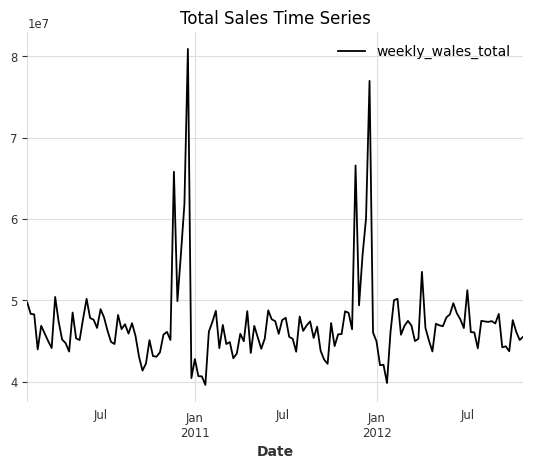

In [79]:
sales_copy.plot(title='Total Sales Time Series')
plt.show()

In [80]:
stores_groups = sales.Store.unique().tolist()
dept_groups = sales.Dept.unique().tolist()
# Separate timeseries
for i in stores_groups:
    sales_store_temp = (sales
                        .query('Store == @i') # Filtrar tienda
                        .groupby(['Date']) # Agrupar por fecha
                        .agg({'Weekly_Sales':'sum'}) # Funcion de agregacion
                        .rename(columns={'Weekly_Sales':f'weekly_sales_store_{i}'}) #Renombrar columna para concatenacion
                        ) 
    
    sales_copy = sales_copy.join(sales_store_temp, how='left')

for i in dept_groups:
    sales_dept_temp = (sales
                       .query('Dept == @i')
                       .groupby(['Date'])
                       .agg({'Weekly_Sales':'sum'})
                       .rename(columns={'Weekly_Sales':f'weekly_sales_dept_{i}'})
                       )
    sales_copy = sales_copy.join(sales_dept_temp, how='left')

In [81]:
stores_columns = [f'weekly_sales_store_{i}' for i in stores_groups]
dept_columns = [f'weekly_sales_dept_{i}' for i in dept_groups]

print(np.round((sales_copy[stores_columns].sum(axis=1) - sales_copy['weekly_wales_total']).sum(axis=0)))

print(np.round((sales_copy[dept_columns].sum(axis=1) - sales_copy['weekly_wales_total']).sum(axis=0)))


0.0
0.0


No se utilizar covariables externas a la serie, debido a la forma en la que esta implementados los modelos con jerarquia en Darts, no es posible agregar covariables para cada caso en particular en un mismo dataframe.

In [82]:
sales_copy.isna().sum()[sales_copy.isna().sum() > 1]

weekly_sales_dept_51     12
weekly_sales_dept_47      5
weekly_sales_dept_78     61
weekly_sales_dept_99     49
weekly_sales_dept_43    131
weekly_sales_dept_39    127
weekly_sales_dept_77    108
dtype: int64

In [87]:
sales_copy = sales_copy.reset_index()

In [158]:
hierarchical_structure1 = {dept:['weekly_wales_total'] for dept in dept_columns}
hierarchical_structure2 = {store:['weekly_wales_total'] for store in stores_columns}

hierarchical_structure = hierarchical_structure1 | hierarchical_structure2

In [159]:
from darts.timeseries import TimeSeries

sales_copy = sales_copy.fillna(0)

In [160]:
data_ts = TimeSeries.from_dataframe(sales_copy,
                                    time_col='Date',
                                    hierarchy=hierarchical_structure)

In [214]:
from darts.models.forecasting.xgboost import XGBModel
from darts.models.forecasting.lgbm import LightGBMModel

In [206]:
training, testing = data_ts.split_before(0.75)

In [215]:
model_xgb = XGBModel(lags=[-1,-2,-5])
model_xgb.fit(training)

predictions_xgb = model_xgb.predict(n=len(testing),
                            series=training)

model_lgbm = LightGBMModel(lags=[-1,-2,-5])
model_lgbm.fit(training)

predictions_lgbm = model_lgbm.predict(n=len(testing),
                                      series=training)

<Axes: xlabel='Date'>

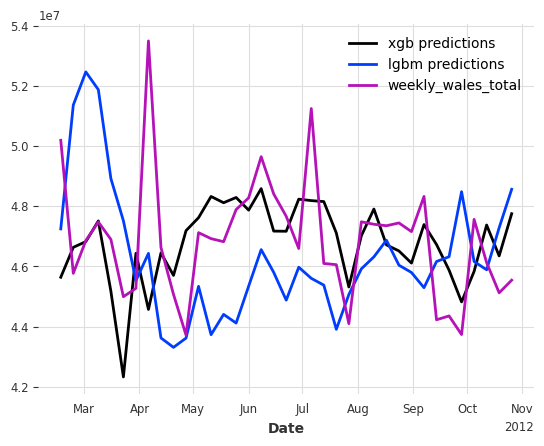

In [216]:
predictions_xgb['weekly_wales_total'].plot(label='xgb predictions')
predictions_lgbm['weekly_wales_total'].plot(label='lgbm predictions')
testing['weekly_wales_total'].plot()

In [217]:
from darts.dataprocessing.transformers.reconciliation import MinTReconciliator

In [218]:
reconcilator = MinTReconciliator()
reconcilator.fit(training)

reconcilied_preds_xgb = reconcilator.transform(predictions_xgb)
reconcilied_preds_lgbm = reconcilator.transform(predictions_lgbm)

<Axes: xlabel='Date'>

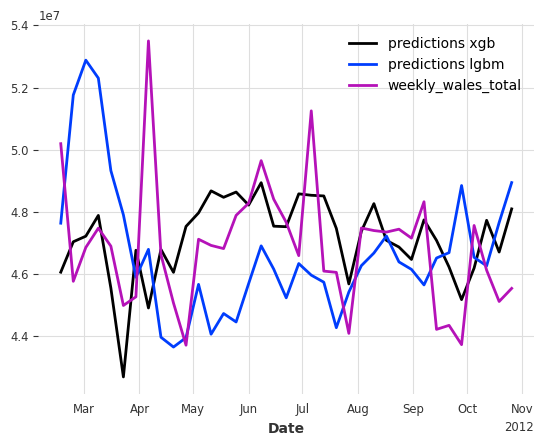

In [221]:
reconcilied_preds_xgb['weekly_wales_total'].plot(label='predictions xgb')
reconcilied_preds_lgbm['weekly_wales_total'].plot(label='predictions lgbm')
testing['weekly_wales_total'].plot()

<Axes: xlabel='Date'>

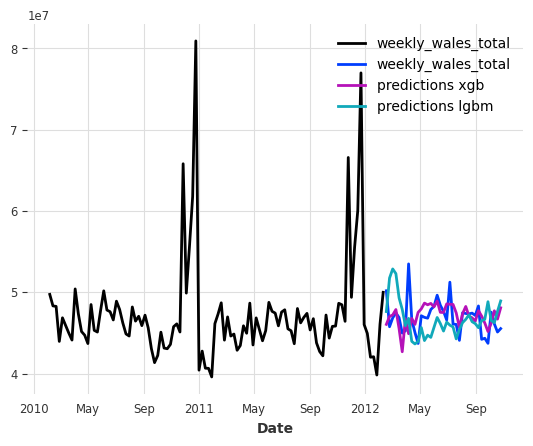

In [222]:
training['weekly_wales_total'].plot()
testing['weekly_wales_total'].plot()
reconcilied_preds_xgb['weekly_wales_total'].plot(label='predictions xgb')
reconcilied_preds_lgbm['weekly_wales_total'].plot(label='predictions lgbm')

Herarchical by group store

In [227]:
type_store = {row.Store:row.Type for _,row in stores.iterrows()}

In [229]:
sales['Type'] = sales['Store'].map(type_store)

In [233]:
sales_copy_group = (sales
              .groupby('Date')
              .agg({'Weekly_Sales':'sum'})
              .rename(columns={'Weekly_Sales':'weekly_wales_total'}))

In [237]:
sales_copy_group

,weekly_wales_total
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


In [238]:
stores_groups = sales.Store.unique().tolist()
store_type = sales.Type.unique().tolist()
# Separate timeseries
for i in stores_groups:
    sales_store_temp = (sales
                        .query('Store == @i') # Filtrar tienda
                        .groupby(['Date']) # Agrupar por fecha
                        .agg({'Weekly_Sales':'sum'}) # Funcion de agregacion
                        .rename(columns={'Weekly_Sales':f'weekly_sales_store_{i}'}) #Renombrar columna para concatenacion
                        ) 
    
    sales_copy_group = sales_copy_group.join(sales_store_temp, how='left')

for i in store_type:
    sales_type_temp = (sales
                       .query('Type == @i')
                       .groupby(['Date'])
                       .agg({'Weekly_Sales':'sum'})
                       .rename(columns={'Weekly_Sales':f'weekly_sales_type_{i}'})
                       )
    sales_copy_group = sales_copy_group.join(sales_type_temp, how='left')

In [240]:
stores_columns = [f'weekly_sales_store_{i}' for i in stores_groups]
type_columns = [f'weekly_sales_type_{i}' for i in store_type]

In [245]:
stores_A = [f'weekly_sales_store_{i}' for i in stores.query('Type == "A"').Store.unique().tolist()]
stores_B = [f'weekly_sales_store_{i}' for i in stores.query('Type == "B"').Store.unique().tolist()]
stores_C = [f'weekly_sales_store_{i}' for i in stores.query('Type == "C"').Store.unique().tolist()]

In [262]:
hierarchical_structure_stores_A = {i:['weekly_sales_type_A'] for i in stores_A}
hierarchical_structure_stores_B = {i:['weekly_sales_type_B'] for i in stores_B}
hierarchical_structure_stores_C = {i:['weekly_sales_type_C'] for i in stores_C}

hierarchical_structure_groups = {i:['weekly_wales_total'] for i in type_columns}

hierarchical_structure_by_groups = hierarchical_structure_stores_A | hierarchical_structure_stores_B | hierarchical_structure_stores_C | hierarchical_structure_groups

In [275]:
data_ts_hierachical = TimeSeries.from_dataframe(sales_copy_group.reset_index(),
                                                time_col='Date',
                                                hierarchy=hierarchical_structure_by_groups)

In [283]:
from darts.dataprocessing.transformers.scaler import Scaler

In [284]:
train, test = data_ts_hierachical.split_before(0.75)

scaler = Scaler()
scaler.fit(train)

train = scaler.transform(train)

In [293]:
model_hierarchical = XGBModel(lags=[-1,-2,-5])
model_hierarchical.fit(train)

predictions_hierarchical = model_hierarchical.predict(len(test),
                                                      series=train)

predictions_hierarchical = scaler.inverse_transform(predictions_hierarchical)

<Axes: xlabel='Date'>

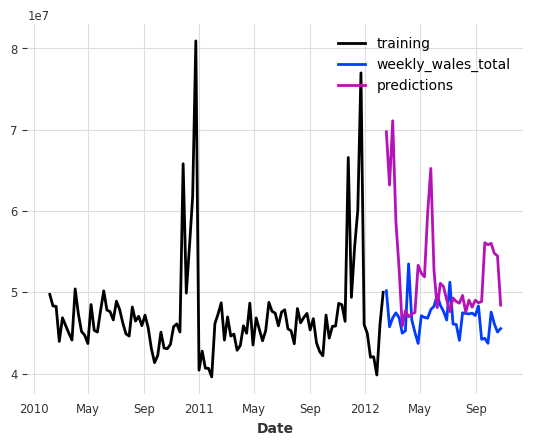

In [294]:
training['weekly_wales_total'].plot(label='training')
test['weekly_wales_total'].plot()
predictions_hierarchical['weekly_wales_total'].plot(label='predictions')